In [18]:
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import pandas as pd
from IPython.display import Image
from copy import deepcopy

# Examine model output: netCDF data storage

In [19]:
nc = './data/surface_chem_E3SM_v0_MOA.nc'
nc = netcdf_dataset(nc)

In [20]:
print(nc.dimensions)
print(nc.variables)

OrderedDict([('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 12
), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 192
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 288
), ('lev', <class 'netCDF4._netCDF4.Dimension'>: name = 'lev', size = 1
), ('ilev', <class 'netCDF4._netCDF4.Dimension'>: name = 'ilev', size = 31
)])
OrderedDict([('P0', <class 'netCDF4._netCDF4.Variable'>
>f8 P0()
    long_name: reference pressure
    units: Pa
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
), ('PS', <class 'netCDF4._netCDF4.Variable'>
>f4 PS(time, lat, lon)
    units: Pa
    long_name: Surface pressure
    cell_methods: time: mean within years time: mean over years
unlimited dimensions: time
current shape = (12, 192, 288)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('Q', <class 'netCDF4._netCDF4.Variable'>
>f4 Q(time, lev, lat, lon)
    mdims: 9
    u

In [21]:
variable_names =  ["mom_a1", "mom_a2", "mom_a3", "mom_a4",
                   "mom_c1", "mom_c2", "mom_c3", "mom_c4",
                   "ncl_a1", "ncl_a2", "ncl_a3",
                   "ncl_c1", "ncl_c2", "ncl_c3",
                   "pom_a1", "pom_a3", "pom_a4",
                   "pom_c1", "pom_c3", "pom_c4",
                   "soa_a1", "soa_a2", "soa_a3",
                   "soa_c1", "soa_c2", "soa_c3",
                   "so4_a1", "so4_a2", "so4_a3",
                   "so4_c1", "so4_c2", "so4_c3",
                   "dst_a1", "dst_a3",
                   "dst_c1", "dst_c3",
                   "bc_a1", "bc_a3", "bc_a4",
                   "bc_c1", "bc_c3", "bc_c4",
                   "num_a1", "num_a2", "num_a3", "num_a4",
                   "num_c1", "num_c2", "num_c3", "num_c4",
                   "wat_a1", "wat_a2", "wat_a3", "wat_a4",
                   "Q", "PS", "T",
                   "dgnd_a01", "dgnd_a02",
                   "dgnd_a03", "dgnd_a04"]
month_names = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]

In [22]:
t = nc.dimensions['time']
lat = nc.variables['lat']
lon = nc.variables['lon']
varname = 'PS'

In [23]:
var = nc.variables[varname]
print(var[:]) #to access just the array of the variable
print(var[:].shape)

[[[ 69077.625  69077.516  69077.164 ...  69076.58   69077.164  69077.516]
  [ 69321.68   69321.68   69321.68  ...  69321.68   69321.68   69321.68 ]
  [ 70381.86   70381.516  70380.48  ...  70378.75   70380.48   70381.516]
  ...
  [101393.25  101393.26  101393.3   ... 101393.35  101393.3   101393.26 ]
  [101429.44  101429.44  101429.44  ... 101429.44  101429.44  101429.44 ]
  [101435.12  101435.125 101435.13  ... 101435.15  101435.13  101435.125]]

 [[ 68932.71   68932.59   68932.234 ...  68931.64   68932.234  68932.59 ]
  [ 69182.18   69182.18   69182.18  ...  69182.18   69182.18   69182.18 ]
  [ 70254.19   70253.84   70252.8   ...  70251.05   70252.8    70253.84 ]
  ...
  [101679.63  101679.66  101679.72  ... 101679.836 101679.72  101679.66 ]
  [101748.99  101748.99  101748.99  ... 101748.99  101748.99  101748.99 ]
  [101760.125 101760.13  101760.15  ... 101760.17  101760.15  101760.13 ]]

 [[ 68366.09   68365.97   68365.6   ...  68364.984  68365.6    68365.97 ]
  [ 68624.22   68624.2

# Plot global map of species concentration

In [24]:
##calculate global concentration for all species
num_names =["num_a1", "num_a2", "num_a3", "num_a4",
            "num_c1", "num_c2", "num_c3", "num_c4"]

empty_array = np.zeros_like(nc.variables[num_names[0]])
empty_array = empty_array.reshape(12,192,288)

num_sum = deepcopy(empty_array)

for i in range(len(num_names)): #add modes together (lat/lon/time pointwise)
    num_sum+=nc.variables[num_names[i]][:,0,:,:]

##Calculate moist density
# Vapor pressure
vapor_pressure = deepcopy(empty_array)
vapor_pressure = nc.variables['Q'][:,0,:,:]/(nc.variables['Q'][:,0,:,:]+0.622) * nc.variables['PS'][:] 
# Moist air density [kg/m3]
moist_density = deepcopy(empty_array)
moist_density = (nc.variables['PS'][:] - vapor_pressure)/(287.0531 * nc.variables['T'][:,0,:,:]) + vapor_pressure/(461.4964 * nc.variables['T'][:,0,:,:])

#multiply concentration by moist density to reach aerosol conc per m^3 
    #(lat/lon/time pointwise still)
num_sum_vol = num_sum * moist_density

#take annual average of months (end up with lat/lon array, size 1 in time dimension)
num_sum_vol_avg = np.sum(num_sum_vol,axis=0)/12.

### Code to plot annual average maps (not interactive; maps will be pulled from .png files locally)

## Display global map of annual aerosol concentration

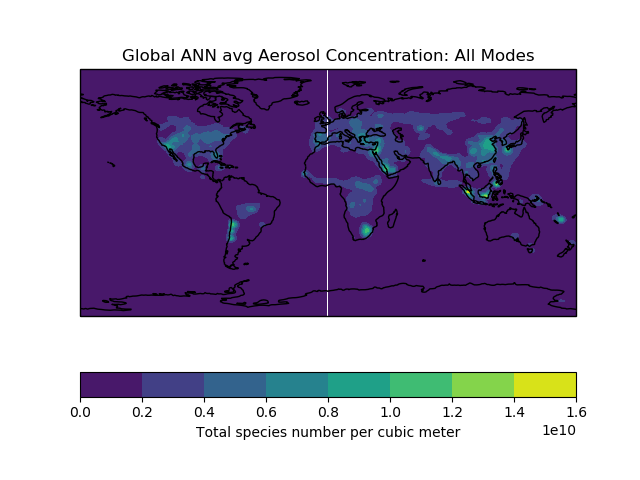

In [25]:
Image(filename='./maps_global_concs/ann_allmodes.png') 

### Select mode number to be displayed (1,2,3,4)

1. 'Accumulation'
2. 'Aitken'
3. 'Coarse'
4. 'Primary Carbon'

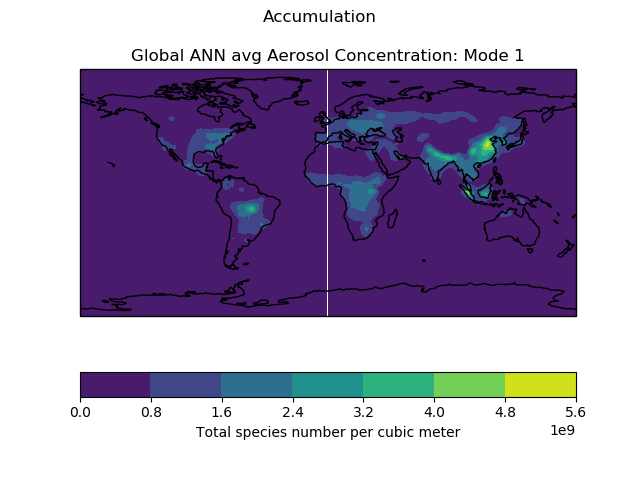

In [26]:
modenum = 1

modelongnames = ['Accumulation','Aitken','Coarse','Primary Carbon']
modelongname = modelongnames[modenum-1]
filename = 'ann_mode'+modelongname+'.png'
Image(filename='./maps_global_concs/'+filename)

## Data processing for single coordinate points (to calculate size distribution)
### Create function to access single coordinate point of data

In [27]:
def geo_idx(dd, dd_array):
    """
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    """
    ##check if input longitude in 180 fmat and convert to 360:
    if(dd_array.max()>180 and dd<0):
        dd = 360 + dd
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

In [30]:
def getPointDF(dirname,filename,in_lat,in_lon,make_csv=True):
    ##open netcdf
    nc = netcdf_dataset(dirname+filename)
    ##pick a point
    lats = nc.variables['lat'][:]
    lons = nc.variables['lon'][:]

    lat_idx = geo_idx(in_lat, lats)
    lon_idx = geo_idx(in_lon, lons)
    ##pull out variables at that point (lev1 only) for each variable (pre-defined list)
    vardf = pd.DataFrame(index=variable_names,columns=month_names)
        #dict/df: key=varname, value=12x1 array retrieved 
    ##pull out 1 layer of variable to add to df -- internal loop
    for varname in variable_names:
        var = nc[varname]
        if (len(var.shape)==3): ##2d var
            vardf.loc[varname,:] = var[:,lat_idx,lon_idx]
        elif(len(var.shape)==4): ##3d var
            vardf.loc[varname,:] = var[:,0,lat_idx,lon_idx]
    ##write to csv with newfilename
    if(make_csv):
        newfilename = dirname+filename.split(".")[0]+'_'+str(in_lat)+'_'+str(in_lon)+".csv"
        vardf.to_csv(newfilename)
    return(vardf)

### Name netcdf input file and lat-lon coordinate of selected point

In [31]:
##inputs: filename, in_lat, in_lon
dirname='./data/'
filename='surface_chem_E3SM_v0_MOA.nc'

in_lat = 44.67
in_lon = -79.5

In [32]:
df = getPointDF(dirname,filename,in_lat,in_lon,make_csv=True)
df.head(5)

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
mom_a1,2.86486e-12,3.00054e-12,4.61063e-12,5.18094e-12,5.83792e-12,6.58645e-12,9.75518e-12,8.31836e-12,7.17736e-12,1.44659e-11,1.05157e-11,3.63733e-12
mom_a2,4.92153e-15,6.96487e-15,1.38246e-14,2.01735e-14,1.70361e-14,6.73186e-15,6.00443e-15,5.58116e-15,8.82869e-15,2.67949e-14,2.40491e-14,8.6945e-15
mom_a3,6.71477e-13,8.24689e-13,1.28082e-12,1.50644e-12,1.42496e-12,1.22457e-12,1.73645e-12,1.6015e-12,1.85243e-12,3.60343e-12,2.75451e-12,7.45979e-13
mom_a4,5.57482e-17,4.12091e-17,4.92485e-17,1.02743e-16,7.51113e-17,2.27518e-17,2.17734e-17,6.13977e-17,1.24611e-16,5.80999e-16,6.13565e-16,1.48563e-16
mom_c1,1.82576e-13,9.45613e-14,4.44615e-14,5.96042e-14,1.40173e-13,1.47393e-13,1.4571e-13,1.56089e-13,1.09472e-13,8.66415e-14,1.99344e-13,8.09115e-14


### Choose a new in_lat and in_lon coordinate pair and create a csv using the getPointDF function. 

In [ ]:
in_lat_new = 
in_lon_new = #-180:180 or 0:360 format OK

df_new = getPointDF(dirname,filename,in_lat_new,in_lon_new,make_csv=)
df_new.head(5)